In [7]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [8]:
spark = SparkSession.builder.getOrCreate()

In [9]:
msnpc = spark.read.csv("Query + Visualization/MsNPC.csv", header=True, inferSchema=True)
msplayer = spark.read.csv("Query + Visualization/MsPlayer.csv", header=True, inferSchema=True)
msweapon = spark.read.csv("Query + Visualization/MsWeapon.csv", header=True, inferSchema=True)
msweapontype = spark.read.csv("Query + Visualization/MsWeaponType.csv", header=True, inferSchema=True)
transactiondetail = spark.read.csv("Query + Visualization/TransactionDetail.csv", header=True, inferSchema=True)
transactionheader = spark.read.csv("Query + Visualization/TransactionHeader.csv", header=True, inferSchema=True)

msnpc.registerTempTable("MsNPC")
msplayer.registerTempTable("MsPlayer")
msweapon.registerTempTable("MsWeapon")
msweapontype.registerTempTable("MsWeaponType")
transactiondetail.registerTempTable("TransactionDetail")
transactionheader.registerTempTable("TransactionHeader")

In [22]:
res1 = spark.sql("SELECT WeaponTypeName, SUM((Quantity * WeaponPrice)/100) AS WeaponPercent FROM MsWeaponType wt, MsWeapon w, TransactionDetail td, TransactionHeader th WHERE wt.WeaponTypeId = w.WeaponTypeId AND w.WeaponId = td.WeaponId AND td.TransactionId = th.TransactionId AND YEAR(TransactionDate) = 2019 GROUP BY WeaponTypeName ORDER BY WeaponPercent ASC LIMIT 5")
res1 = res1.toPandas()

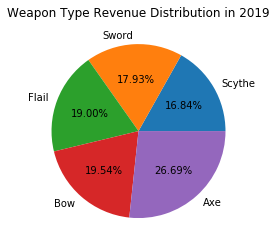

In [95]:
plt.title("Weapon Type Revenue Distribution in 2019")
plt.pie(res1["WeaponPercent"], labels=res1["WeaponTypeName"], autopct = "%.2f%%")
plt.show()

In [31]:
res2 = spark.sql("SELECT COUNT(DISTINCT p.PlayerId) AS TotalPlayer, MONTH(TransactionDate) AS Month FROM MsPlayer p, TransactionHeader th, TransactionDetail td, MsWeapon w, MsWeaponType wt WHERE p.PlayerId = th.PlayerId AND th.TransactionId = td.TransactionId AND td.WeaponId = w.WeaponId AND w.WeaponTypeId = wt.WeaponTypeId AND WeaponTypeName LIKE 'Axe' AND YEAR(TransactionDate) = 2019 GROUP BY MONTH(TransactionDate) ORDER BY MONTH(TransactionDate)")
res2 = res2.toPandas()
res2

,TotalPlayer,Month
0,8,1
1,7,2
2,5,3
3,6,4
4,4,5
5,5,6
6,4,7
7,3,8
8,1,9
9,6,10


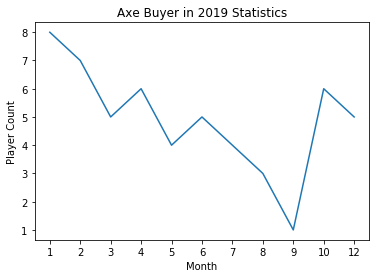

In [33]:
plt.plot(res2["TotalPlayer"])
plt.xticks(range(len(res2["Month"])), res2["Month"])
plt.title("Axe Buyer in 2019 Statistics")
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.show()

In [51]:
res3 = spark.sql("SELECT x.SpecialWeapon, COUNT(x.SpecialWeapon) AS Frequency FROM(SELECT p.PlayerId, CASE WHEN sum(WeaponPrice*Quantity) >2000000 THEN 'Extinction' WHEN SUM(WeaponPrice*Quantity) >=1500000 AND SUM(WeaponPrice*Quantity) <=1999999 THEN 'Nightfall' WHEN SUM(WeaponPrice*Quantity)>=1000000 THEN 'Stormbreaker' END AS SpecialWeapon FROM MsPlayer p,TransactionHeader th, TransactionDetail td, MsWeapon w WHERE p.PlayerId = th.PlayerId AND th.TransactionId = td.TransactionId AND td.WeaponId = w.WeaponId AND PlayerGender LIKE 'Female' AND YEAR(TransactionDate) = 2019 GROUP BY p.PlayerId,  MONTH(TransactionDate) ORDER BY SUM(WeaponPrice*Quantity) DESC)AS x GROUP BY x.SpecialWeapon ORDER BY Frequency DESC LIMIT 3")
res3 = res3.toPandas()
res3

,SpecialWeapon,Frequency
0,Stormbreaker,17
1,Nightfall,9
2,Extinction,7


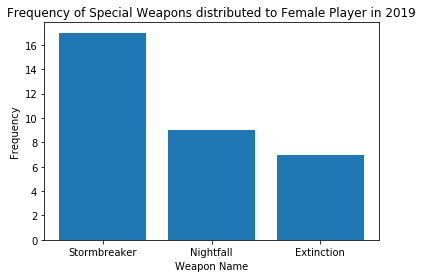

In [54]:
plt.bar(res3["SpecialWeapon"], res3["Frequency"])
plt.title("Frequency of Special Weapons distributed to Female Player in 2019")
plt.xlabel("Weapon Name")
plt.ylabel("Frequency")
plt.show()

In [94]:
res4 = spark.sql("SELECT MONTH(ht.TransactionDate) AS Month, COUNT(DISTINCT(p.PlayerId)) AS TotalPlayer FROM MsPlayer p ,TransactionHeader ht, TransactionDetail td, MsWeapon w, MsWeaponType wt WHERE p.PlayerId = ht.PlayerId AND td.TransactionId = ht.TransactionId AND w.WeaponId = td.WeaponId AND wt.WeaponTypeId = w.WeaponTypeId AND YEAR(ht.TransactionDate) = 2019 GROUP BY Month HAVING COUNT (wt.WeaponTypeId) >=3 ORDER BY Month")
res4 = res4.toPandas()
res4

,Month,TotalPlayer
0,1,11
1,2,10
2,3,7
3,4,8
4,5,5
5,6,11
6,7,10
7,8,9
8,9,3
9,10,12


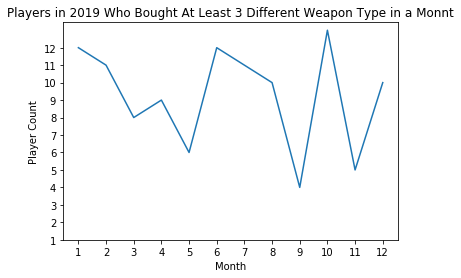

In [88]:
plt.plot(res4["TotalPlayer"])
plt.xticks(range(len(res4["Month"])), res4["Month"])
plt.yticks(range(len(res4["TotalPlayer"])), res4["Month"])
plt.title("Players in 2019 Who Bought At Least 3 Different Weapon Type in a Month")
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.show()

In [91]:
res5 = spark.sql("SELECT x.Popularity, COUNT(x.Popularity) AS Frequency FROM (SELECT n.NPCId,CASE WHEN SUM(WeaponPrice*Quantity) >=15000000 THEN 'VeryPopular' WHEN SUM(WeaponPrice*Quantity) >=7500000 AND SUM(WeaponPrice*Quantity) <=14999999 THEN 'Popular' WHEN SUM(Weaponprice*Quantity) >=2500000 AND SUM(WeaponPrice*Quantity) <=7499999 THEN 'QuitePopular' END AS Popularity FROM MsNPC n,TransactionHeader th, TransactionDetail td, MsWeapon w WHERE n.NPCId = th.NPCId AND th.TransactionId = td.TransactionId AND td.WeaponId = w.WeaponId GROUP BY n.NPCId)AS x GROUP BY x.Popularity ORDER BY x.Popularity DESC LIMIT 3")
res5 = res5.toPandas()
res5

,Popularity,Frequency
0,VeryPopular,2
1,QuitePopular,5
2,Popular,8


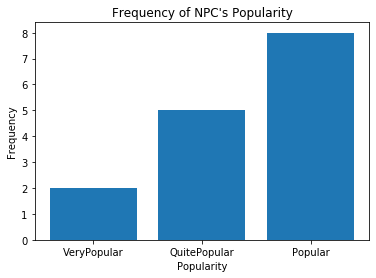

In [92]:
plt.bar(res5["Popularity"], res5["Frequency"])
plt.title("Frequency of NPC's Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()